In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential, Input, InputLayer, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, LeakyReLU, BatchNormalization, Reshape
from keras import metrics, layers
from keras.callbacks import Callback
from keras.optimizers import Adam
from keras.datasets import mnist
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score

Using TensorFlow backend.


In [6]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        #print('\n val_f1: %f — val_precision: %f — val_recall %f' %(_val_f1, _val_precision, _val_recall))
        return

## Define a class that represents the GAN
- The constructor instantiates both the discriminator and generator
- Contains methods to fit and output predictions

In [7]:
class Generative_adversarial_network():
    
    # define the constructor
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        
        # one channel - greyscale images
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        optimizer = Adam(0.0002, 0.5)
        
        self.discriminator_acc_list = []
        self.discriminator_loss_list = []
        self.generator_loss_list = []
        
        # construct field representing the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
                                   optimizer=optimizer, 
                                   metrics=['accuracy'])
        
        # construct field representing the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', 
                               optimizer=optimizer)
        
        # input shape of the generator - takes noise and outputs an image
        # imput shape is a vector of 100 length
        z = Input(shape=(100, ))
        
        # the generated image
        img_produced = self.generator(z)
        
        # we will only train the generator with the combined network
        self.discriminator.trainable = False
        
        # take images as input to discriminator and determine the y_hat
        discriminator_y_hat = self.discriminator(img_produced)
        
        # the combined GAN model compiled: (we are only fitting the generator here)
        self.combined_gan = Model(z, discriminator_y_hat)
        self.combined_gan.compile(loss='binary_crossentropy', optimizer=optimizer)
        
    def build_generator(self):
        noise_shape = (100, )
        model = Sequential()
        
        # the first layer is made of 256 densely connected units
        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        
        # the last layer is sized as the area of the input units reshaped as a square:
        # rows x cols x channels
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))
        
        model.summary()
        
        noise = Input(shape=noise_shape)
        image = model(noise)
        
        return Model(noise, image)
    
    def build_discriminator(self):
        img_shape = (self.img_rows, self.img_cols, self.channels)
        model = Sequential()
        
        # take a 2D image and flatten it to a 1D vector of input units
        model.add(Flatten(input_shape=img_shape))
        
        # second layer is 512 units
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        
        # create the output layer of one unit:
        # activation is sigmoid (0, 1)
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        
        image = Input(shape=img_shape)
        y_hat = model(image)
        
        return Model(image, y_hat)
    
    def train(self, epochs, batch_size=128, save_interval=50):
        
        # load the MNIST data set
        (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
        
        # scale the features of the dataset to the active range of the tanh function
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        
        # expand the shape of the 1D array
        X_train = np.expand_dims(X_train, axis=3)
        half_batch = int(batch_size / 2)
        
        # train the model
        for epoch in range(epochs):
            
            # train the discriminator ---------------------
            
            # select a random half batch of images
            indexes = np.random.randint(low=0, high=X_train.shape[0], size=half_batch)
            images_half_batch = X_train[indexes]
            
            # generate some random noise to feed to generator
            noise = np.random.normal(0, 1, (half_batch, 100))
            
            # generate some new images
            gen_images = self.generator.predict(noise)
            
            # real images are labeled as 1 here:
            discriminator_loss_real = self.discriminator.train_on_batch(images_half_batch, np.ones((half_batch, 1)))
            # noise images are labeled as 0 here:
            discriminator_loss_fake = self.discriminator.train_on_batch(gen_images, np.zeros((half_batch, 1)))
            
            # get the total combined loss of both real and fake predictions
            discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)
            
            # train the generator -------------------------
            
            noise = np.random.normal(0, 1, (batch_size, 100))
            
            # the generator is going to want the opposition to label the generated images as 1:
            # create a vector of ones as y_train:
            y_train = np.array([1] * batch_size)
            
            generator_loss = self.combined_gan.train_on_batch(noise, y_train)
            
            #print('%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]' % (epoch, discriminator_loss[0], 100*discriminator_loss[1], generator_loss))
            
            # append results to the fields:
            self.discriminator_loss_list.append(discriminator_loss[0])
            self.discriminator_acc_list.append(discriminator_loss[1])
            self.generator_loss_list.append(generator_loss)
            
            # periodically save generated fake images
            if epoch % save_interval == 0:
                self.save_images(epoch)
        
    def save_images(self, epoch):
        rows, cols = 5, 5
        noise = np.random.normal(0, 1, (rows * cols, 100))
        gen_images = self.generator.predict(noise)
        gen_images = 0.5 * gen_images + 0.5
        
        fig, axs = plt.subplots(rows, cols)
        count = 0
        for i in range(rows):
            for j in range(cols):
                axs[i,j].imshow(gen_images[count, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                count += 1
        fig.savefig("gan/images/mnist_%d.png" % epoch)
        plt.close()

## Instantiate the GAN and train the combined model:

In [8]:
gan = Generative_adversarial_network()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

In [9]:
gan.train(epochs=30000, batch_size=32, save_interval=1000)

C:\Users\ericn\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


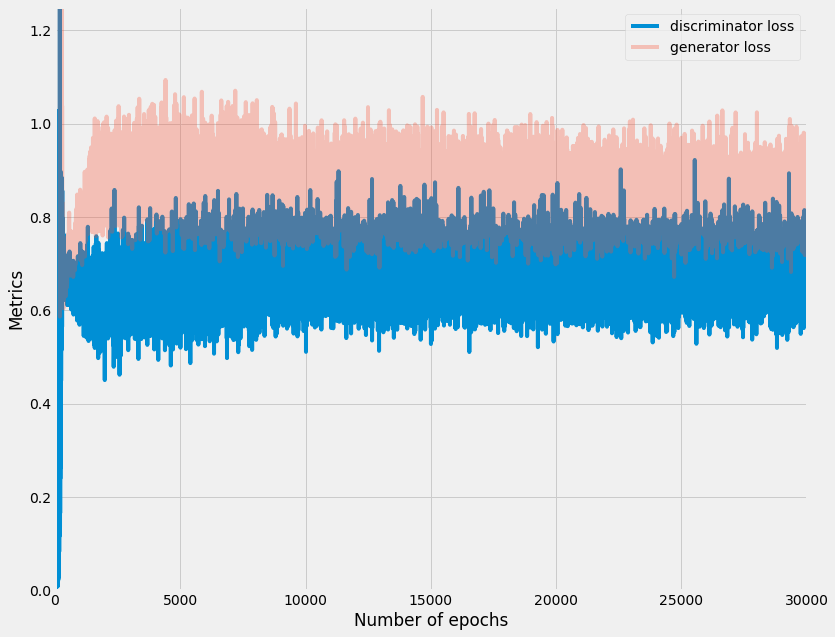

In [14]:
plt.figure(figsize=(12, 10))
plt.style.use('fivethirtyeight')
x_units = list(range(1, 30001))
plt.plot(x_units, gan.discriminator_loss_list, label='discriminator loss')
#plt.plot(x_units, gan.discriminator_acc_list, label='discriminator accuracy', alpha=0.3)
plt.plot(x_units, gan.generator_loss_list, label='generator loss', alpha=0.3)

# xmin xmax ymin ymax
plt.axis([0, 30000, 0, 1.25])
plt.xlabel('Number of epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

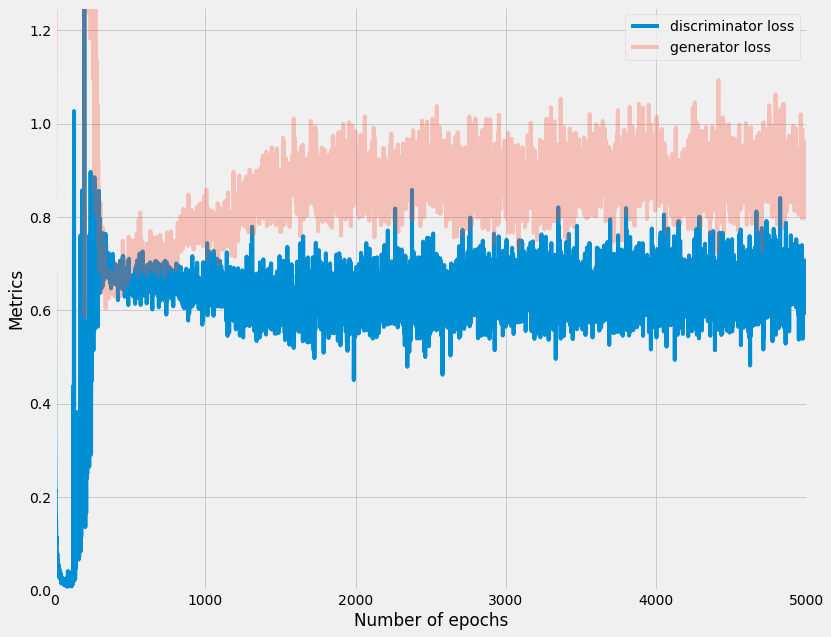

In [16]:
plt.figure(figsize=(12, 10))
x_units = list(range(1, 5001))
plt.plot(x_units, gan.discriminator_loss_list[:5000], label='discriminator loss')
#plt.plot(x_units, gan.discriminator_acc_list, label='discriminator accuracy', alpha=0.3)
plt.plot(x_units, gan.generator_loss_list[:5000], label='generator loss', alpha=0.3)

# xmin xmax ymin ymax
plt.axis([0, 5000, 0, 1.25])
plt.xlabel('Number of epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

**Epoch Number 1:**

![epoch number 1](gan/images/mnist_0.png)

**Epoch Number 1000:**

![epoch number 1000](gan/images/mnist_1000.png)

**Epoch Number 2000:**

![epoch number 2000](gan/images/mnist_2000.png)

**Epoch Number 8000:**

![epoch number 8000](gan/images/mnist_8000.png)

**Epoch Number 20,000:**

![epoch number 20,000](gan/images/mnist_20000.png)

**Epoch Number 29,000:**

![epoch number 29,000](gan/images/mnist_29000.png)